# Måle inn punkt med GNSS
Vi skal måle gjennomsnitt på de forskjellige måtene vi har samlet inn data. Vi har en KML fil med data fra RTK'n, og et datasett fra telefon. Importerer først pakker vi trenger for å behandle dataen.

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import pyproj

## Gjennomsnitt ved RTK målinger
Først får vi ut koordinatene fra KML filen og lagrer det i et array.

In [2]:
def extract_coordinates_kml_RTK (kml_file):
    tree = ET.parse(kml_file)
    root = tree.getroot()
    
    # Namespace er noe vi må ha med siden det ikke er en XML fil
    namespace = {'kml': 'http://www.opengis.net/kml/2.2'}

    # Går igjennom alle punktene - må her også ha spesielt format pga kml-fil

    coordinates = []

    for placemark in root.findall('.//kml:Placemark', namespace):
            longitude = placemark.find('.//kml:SimpleData[@name="Longitude"]', namespace).text
            latitude = placemark.find('.//kml:SimpleData[@name="Latitude"]', namespace).text
            coordinates.append([float(longitude), float(latitude)])
    return coordinates

extract_coordinates_kml_RTK('dataset/RTK.kml')

[[10.77530275, 59.66589043],
 [10.77530274, 59.66589059],
 [10.7753027, 59.6658904],
 [10.77530269, 59.66589036],
 [10.77530294, 59.6658903],
 [10.77530266, 59.66589073],
 [10.77530263, 59.66589051]]

Lager en kode for å skrive koordinat arrayet til csv fil for bruk i forelesing 21.08

In [3]:
import csv

def write_coordinates_to_csv(coordinates, filename='coordinates.csv'):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Write header
        csv_writer.writerow(['Longitude', 'Latitude'])
        
        # Write coordinates
        for coord in coordinates:
            csv_writer.writerow(coord)
    
    print(f"Coordinates have been written to {filename}")

write_coordinates_to_csv(extract_coordinates_kml_RTK('dataset/RTK.kml'))

Coordinates have been written to coordinates.csv


Så lager vi en funkjson for å beregne gjennomsnitt:

In [4]:

def average_coordinates(array_input):
    coordinates = np.array(array_input)

    # Må ha axis=0 slik at funksjonen ikke regner ut gjennomsnittet av alle punktene
    average_coordinates_point = np.mean(coordinates, axis=0)
    print('Gjennomsnittskoordinatet er:', average_coordinates_point)


Kjører denne funksjonen på punktene målt med RTK.

In [5]:
average_coordinates(extract_coordinates_kml_RTK('dataset/RTK.kml'))

Gjennomsnittskoordinatet er: [10.77530273 59.66589047]


## Gjennomsnitt ved mobil

Her har vi to ulike måter. Filen vi fikk fra Trygve i tilfelle NMEA dataen viser seg trøblete

### Trygves data

Trekker så ut punktene fra KML filen fra Trygves mobil, og lager ett array av de. Funksjonen blir veldig lik den forrige funksjonen, men med små endringer (Bryter litt med DNRY)

In [6]:
def extract_coordinates_kml_mobil (kml_file):
    tree = ET.parse(kml_file)
    root = tree.getroot()

    # Må bruke http://www.google.com/kml/ext/2.2 her i stedet for klm, siden gx:coord er google spesifik .klm
    namespace = {'gx': 'http://www.google.com/kml/ext/2.2'}

    coordinates = []
    for coord in root.findall('.//gx:coord', namespace):
        #understreken her var kul
        lon, lat, _ = map(float, coord.text.split())
        coordinates.append([lon, lat])

    return coordinates

Kjører så gjennomsnittsfunksjonen for å finne ut gjennomsnittet ved disse målingene

In [7]:
average_coordinates(extract_coordinates_kml_mobil('dataset/trygve_data.kml'))

Gjennomsnittskoordinatet er: [10.77532085 59.6658624 ]


Lager en csv fil for dette også:

In [8]:
write_coordinates_to_csv(extract_coordinates_kml_mobil('dataset/trygve_data.kml'), 'coordinates_trygve_mobil.csv')

Coordinates have been written to coordinates_trygve_mobil.csv


## Scatter plot over dataen

Tror dette kan være kult å ha med i rapporten.

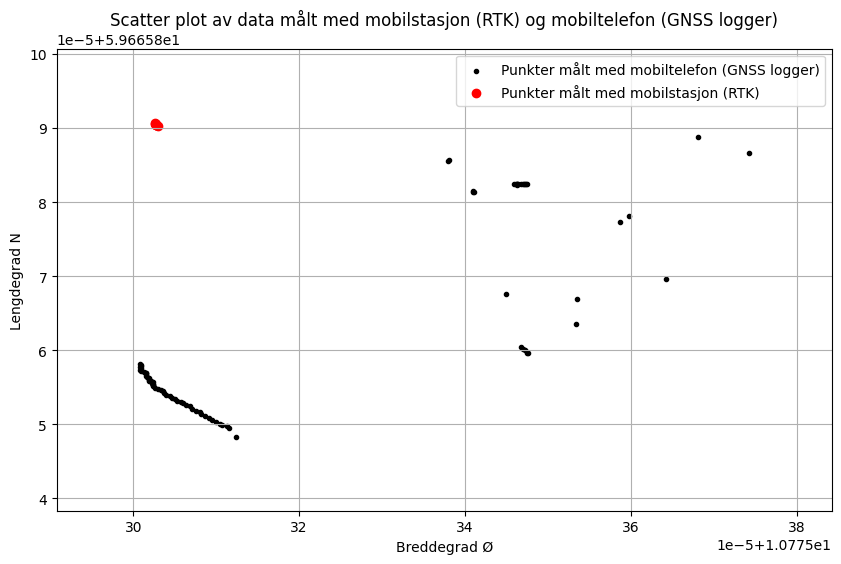

In [9]:
mobile_coordinates = extract_coordinates_kml_mobil('dataset/trygve_data.kml')
rtk_coordinates = extract_coordinates_kml_RTK('dataset/RTK.kml')

# Bruker zip funksjonen for å få (x, y) koordinater
long_mob, lat_mob = zip(*mobile_coordinates)
long_rtk, lat_rtk = zip(*rtk_coordinates)

plt.figure(figsize=(10, 6))

# En variabel for å endre hvor mye rom det er rundt punktene i plottet
space_value = 0.00001

# Justere aksene(?) i forhold til dataen
plt.xlim(min(min(long_mob), min(long_rtk)) - space_value, max(max(long_mob), max(long_rtk)) + space_value)
plt.ylim(min(min(lat_mob), min(lat_rtk)) - space_value, max(max(lat_mob), max(lat_rtk)) + space_value)


plt.scatter(long_mob, lat_mob, c='black', marker='.', label='Punkter målt med mobiltelefon (GNSS logger)')
plt.scatter(long_rtk, lat_rtk, c='red', marker='o', label='Punkter målt med mobilstasjon (RTK)')

# Adding title and labels
plt.title('Scatter plot av data målt med mobilstasjon (RTK) og mobiltelefon (GNSS logger)')
plt.xlabel('Breddegrad Ø')
plt.ylabel('Lengdegrad N')


# Optional: Add grid
plt.grid(True)

# Display the plot with a legend
plt.legend()
plt.show()


Ser her at enhetene på aksene blir helt ville når man somer inn så mye. Gir derfor mye mer mening å bruke UTM 32, som det forsåvidt ble brukt i oppgaveteksten. Lager derfor en funksjon som konverterer fra grader til UTM 32 koordinater. Finner ut av det er et bibliotek som heter `pyproj` som hjelper med dette.

In [10]:
# Brukte chatGPT til å hjelpe til med konverteringen

def convert_to_utm32(coord_pairs):
    # Define the UTM32 (Zone 32N) projection -- Blir dette riktig? Får sjekke mot faktisk koordinat 
    utm_proj = pyproj.Proj(proj='utm', zone=32, ellps='WGS84', south=False)

    # Convert the coordinates and return the combined UTM coordinates
    return list(zip(*utm_proj(*zip(*coord_pairs))))

Plotter så dataen på nytt med UTM32 koordinater

[(600013.7971612128, 6615537.209981232), (600013.7936327328, 6615537.215457613), (600013.7946401128, 6615537.219941183), (600013.7802581304, 6615537.25186694), (600013.7632087748, 6615537.27815056), (600013.7490948552, 6615537.300056088), (600013.6240697306, 6615538.096674924), (600013.7227881374, 6615539.758293127), (600013.7184607735, 6615539.751492429), (600013.7098927493, 6615539.755719835), (600013.7041708048, 6615539.758909228), (600013.6947145403, 6615539.7541996315), (600013.6839530495, 6615539.756140049), (600013.6637055094, 6615539.754484227), (600013.6535966316, 6615539.753099638), (600013.6463636183, 6615539.749563676), (600013.6547827191, 6615539.750903058), (600013.6557033946, 6615539.737557825), (600013.637351474, 6615539.749322583), (600013.1855131561, 6615540.099335455), (600013.178369497, 6615540.092459415), (600014.1145184126, 6615537.651877648), (600014.1087785097, 6615538.034993525), (600014.7057365987, 6615538.349557158), (600015.2199614657, 6615540.260720479), (6

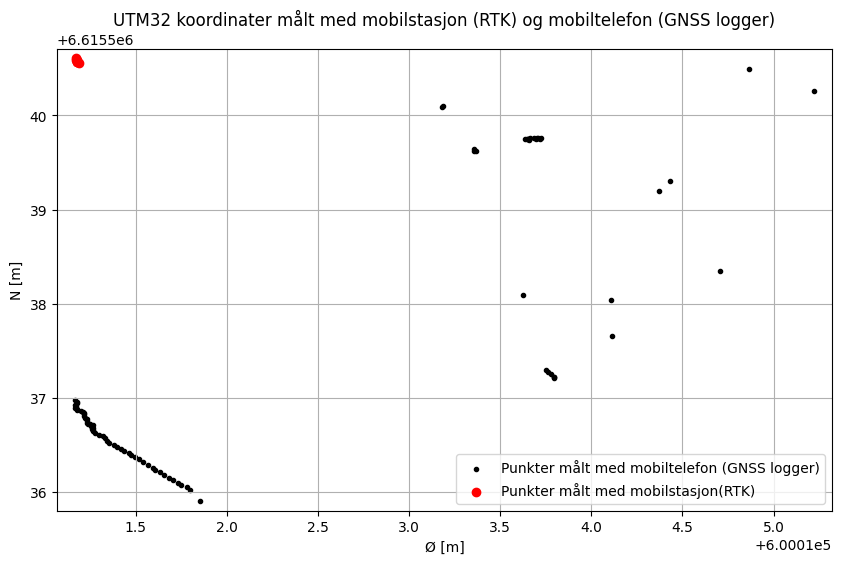

In [11]:
mobile_coordinates = convert_to_utm32(extract_coordinates_kml_mobil('dataset/trygve_data.kml'))
rtk_coordinates = convert_to_utm32(extract_coordinates_kml_RTK('dataset/RTK.kml'))

print(mobile_coordinates)

# Bruker zip funksjonen for å få (x, y) koordinater
long_mob, lat_mob = zip(*mobile_coordinates)
long_rtk, lat_rtk = zip(*rtk_coordinates)

plt.figure(figsize=(10, 6))

# En variabel for å endre hvor mye rom det er rundt punktene i plottet
space_value = 0.1

# Justere aksene(?) i forhold til dataen
plt.xlim(min(min(long_mob), min(long_rtk)) - space_value, max(max(long_mob), max(long_rtk)) + space_value)
plt.ylim(min(min(lat_mob), min(lat_rtk)) - space_value, max(max(lat_mob), max(lat_rtk)) + space_value)


plt.scatter(long_mob, lat_mob, c='black', marker='.', label='Punkter målt med mobiltelefon (GNSS logger)')
plt.scatter(long_rtk, lat_rtk, c='red', marker='o', label='Punkter målt med mobilstasjon(RTK)')

# Adding title and labels
plt.title('UTM32 koordinater målt med mobilstasjon (RTK) og mobiltelefon (GNSS logger)')
plt.xlabel('Ø [m]')
plt.ylabel('N [m]')

# Optional: Add grid
plt.grid(True)

# Display the plot with a legend
plt.legend()
plt.show()

Innser helt på slutten at jeg ikke har tenkt på høydeverdi i hele tatt.. Kan vurdere å skrive om dette på et senere punkt.

Lage csv med UTM32 koordinater

In [12]:
write_coordinates_to_csv(convert_to_utm32(extract_coordinates_kml_mobil('dataset/trygve_data.kml')), 'trygve_mobil_UTM32.csv')

Coordinates have been written to trygve_mobil_UTM32.csv


## Få ut Data fra GNSS Logger appen